# Methylation and Deamination Estimators Simulation

Author: lee.carlin@mail.huji.ac.il  
Date: 2020-03-23  
Last edited: 2020-04-10  

To Do :  
* Find second derivative --> explore what it is 
* Add variance simulations  - comparing the simple model to full  
* Compare my model to Liran's using complex data  
* Is Liran's model using complex data has a bais?   

Table of Contents:  

* [Simple Binomial Model (Liran's Model)](#A-Simple-Binomial-Model)  
* [Position Dependent Binomial Model - No Constant and Fixed Pi](#Position-Dependent-Binomial-Model---No-Constant-and-Fixed-Pi)  
* [Position Dependent Binomial Model - No Constant](#Position-Dependent-Binomial-Model---No-Constant)  
* [Position Dependent Binomial Model](#Position-Dependent-Binomial-Model)  
* [Position Dependent GLM Model](#Position-Dependent-GLM-Model) 

In [1]:
# libraries:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, newton
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy.optimize import fsolve, newton
import scipy.stats as stats  
import time

# A Simple Binomial Model  

Liran models the $t_i$ as a Binomial with parameter $n_i$ and $\pi m_i$:


* $n_i$ is the total coverage at position $i$  
* $t_i, c_i$ are the total numbers of observed T and C bases at $i$ , respectively.   
* $n_i=t_i+c_i$  
* $m_i$ is the methylation level at position $i$, $0<=m_i<=1$  
* $\pi$ is the average deamination rate over all reads.   

$t_i$ is generated according to the following binomial process:    
$t_i \sim Bin(n_i,\pi m_i)$   

The ML:  
$L(\pi m_i|n_i,t_i) = \binom{n_i}{t_i} (\pi m_i)^{t_i}(1-\pi m_i)^{n_i-t_i}$m

The MLE:  
$\hat{\pi m_i}  = \frac{t_i}{n_i}$

### Simulation:

In [2]:
# Setting parameters 
max_n_i = 10000
m_i = 0.7
pi = 0.2
n_i = 30

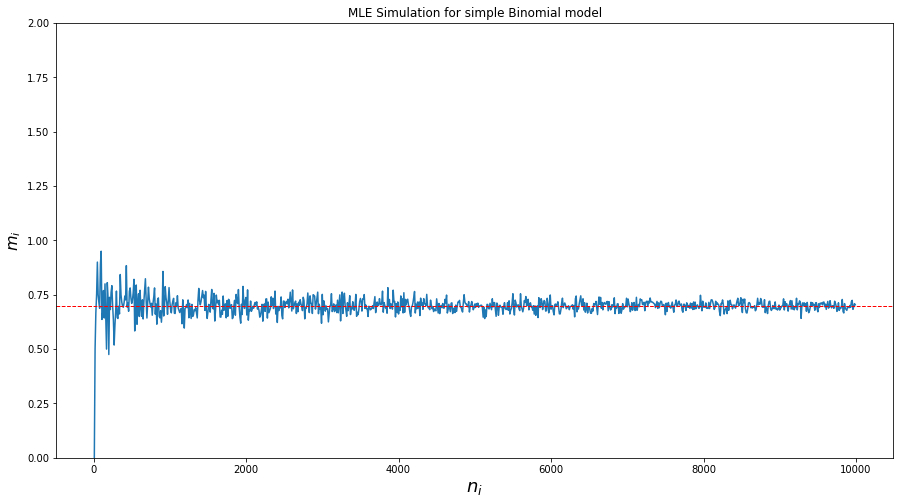

In [3]:
# Sampling datapoints:
est_list = []
rng = range(10,max_n_i,10)
for i in rng:
    # USING BINOMIAL MLE:
    est_list.append(np.random.binomial(1,pi*m_i,i).sum()/(i*pi))
# Plotting simulation:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.plot(list(rng),est_list,)
ax.axhline(y=m_i, color = 'red', ls='--',lw=1)
ax.set_title('MLE Simulation for simple Binomial model')
plt.xlabel('$n_i$', fontsize=18)
plt.ylabel('$m_i$', fontsize=16)
plt.ylim([0,2])
plt.show()

# Position Dependent Binomial Model - No Constant and Fixed Pi

### In this variation the deamination rate is free to vary between read position $j$. 

$t_{i,j} \sim Bern(\theta_{i,j}) \quad \text{where} \quad \theta_{i,j} = \pi_{i,j}^1 m_i +\pi_{i,j}^0  (1- m_i)$  


We first simplify by using a no constant $\theta$:  $\quad \theta_{i,j} = \pi_{i,j}^1 m_i $

### The FOC of the MLE is:

$\frac{ \partial \mathbf{l}(\theta_{i,j})}{ \partial \theta_{i,j}	}  
 =\sum_{t_{i,j}}^{k_i} t_{i,j} \frac{\partial \partial (\theta_{i,j})}{\theta_{i,j}}
 - \sum_{t_{i,j}}^{k_i} (1-t_{i,j}) \frac{\partial \partial (\theta_{i,j})}{1-\theta_{i,j}} $ 
  
  where $ \partial \partial (\theta_{i,j})$ is the partial derivative of $\theta_{i,j}$ with respect to one of its variables. 
 

If we choose to take the partial derivative with respect to $m_i$, then

$\frac{ \partial \mathbf{l}(\theta_{i,j})}{ \partial \theta_{i,j}	}  
=  \sum_{t_{i,j}}^{k_i} t_{i,j} \frac{\pi_{i,j}}{\theta_{i,j}}
- \sum_{t_{i,j}}^{k_i} (1-t_{i,j}) \frac{\pi_{i,j}}{1-\theta_{i,j}}$

### Simulation:

Setting Parameters:

In [4]:
n_i =  30 # number of coverage per read
m_i =  0.7 # min(np.random.uniform(0.7, 0.15),1)
pi_i = 0.2 # fixed pi

Generating simulation for the above parameters:

In [5]:
# MLE with no constant:
def FOC_noConstant(M_i,n_i,pi_i):    
    A = ((t_i*pi_i)/(pi_i*M_i)).sum()
    oneMinusT = np.array([1]*n_i)-np.array(t_i)
    oneMinusTheta = np.array([1]*n_i)-pi_i*M_i
    B = ((oneMinusT*pi_i)/(oneMinusTheta)).sum()
    return (A-B)

Number of coverage per read: 30
The true m_i: 0.700


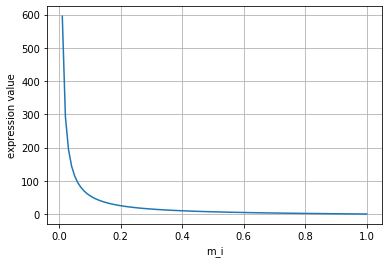

m_i is = 0.7
The solution is m_i = [1.]
at which the value of the expression is -3.552713678800501e-15


In [6]:

# Define the expression whose roots we want to find:
print('Number of coverage per read: {:,}'.format(n_i))
print('The true m_i: {:.3f}'.format(m_i))
# Plot it
t_i = np.random.binomial(1,pi_i*m_i,n_i)

#func = lambda M_i : ((t_i*pi_i)/(pi_i*M_i)).sum()-((np.array([1]*n_i)-np.array(t_i)*pi_i)/(np.array([1]*n_i)-pi_i*M_i)).sum()

MM_i = np.linspace(0.01, 1, 99)
y = []
for i in MM_i:
    y.append(FOC_noConstant(i,n_i,pi_i))

plt.plot(MM_i, y)
plt.xlabel("m_i")
plt.ylabel("expression value")
plt.grid()
plt.show()


m_i_initial_guess = 0.5
#m_i_solution = sp.optimize.brentq(FOC_noConstant,a = 0.1, b = 0.9,args=(n_i,pi_i))
m_i_solution = fsolve(FOC_noConstant, m_i_initial_guess,args=(n_i,pi_i))

print("m_i is = {}".format(m_i))
print("The solution is m_i = {}".format(m_i_solution))
print("at which the value of the expression is {}".format(FOC_noConstant(m_i_solution,n_i,pi_i)))

Plotting a set of simulation where we increase the $n_i$ and observe convergence:

In [7]:
# Parameters:
max_n_i = 10000
m_i =  0.7 # min(np.random.uniform(0.7, 0.15),1)
pi_i = 0.2 # fixed pi

Elapsed (seconds): 8.32


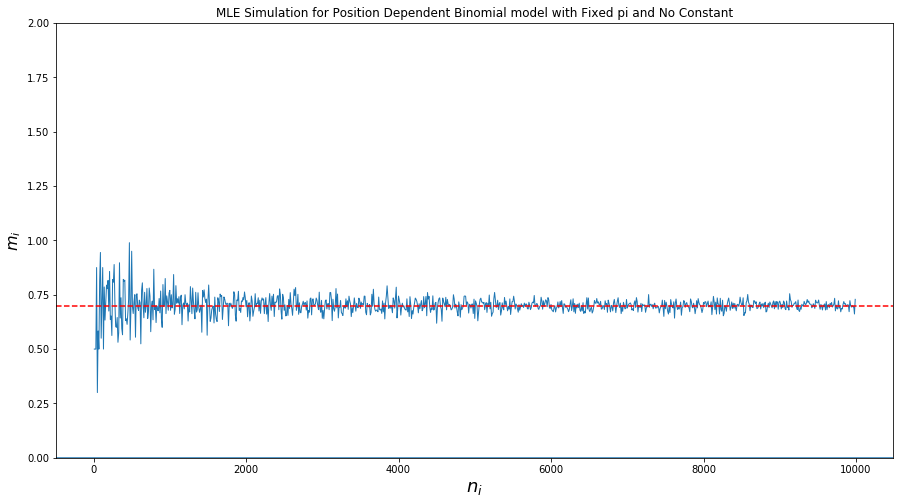

In [8]:
t = time.time()
# Plotting the simulation per coverage size:
est_list = []
rng = range(10,max_n_i,10)
for i in rng:
    t_i = np.random.binomial(1,pi_i*m_i,i)
    solution = fsolve(FOC_noConstant, m_i_initial_guess,args=(i,pi_i))[0]
    est_list.append(solution)
print('Elapsed (seconds): {:,}'.format(round(time.time() - t,2)))
# Plotting simulation:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.plot(list(rng),est_list,lw=1)
ax.axhline(y=m_i, color = 'red', ls='--')
ax.set_title('MLE Simulation for Position Dependent Binomial model with Fixed pi and No Constant')
plt.xlabel('$n_i$', fontsize=18)
plt.ylabel('$m_i$', fontsize=16)
plt.ylim([0,2])
ax.axhline()
plt.show()

Trying with a different optimization method:

Elapsed (seconds): 7.55


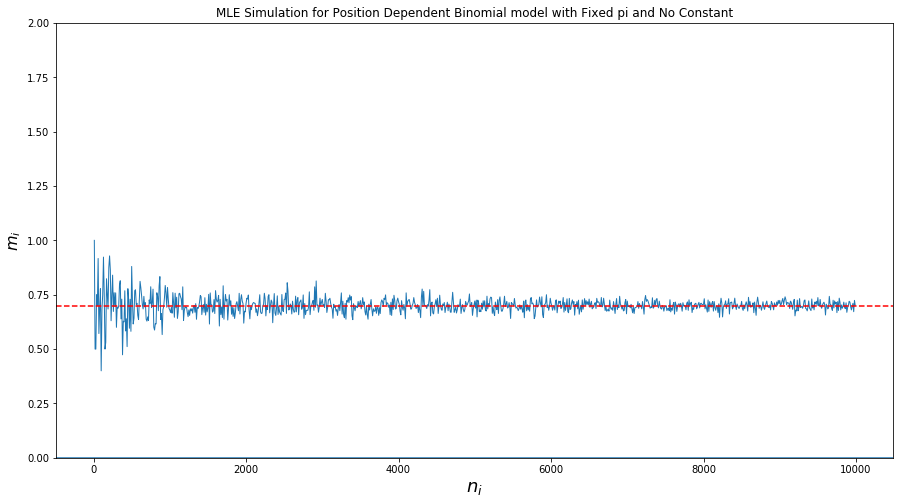

In [14]:
t = time.time()
# Plotting the simulation per coverage size:
est_list = []
rng = range(10,max_n_i,10)
for i in rng:
    t_i = np.random.binomial(1,pi_i*m_i,i)
    #solution = fsolve(FOC_noConstant, m_i_initial_guess,args=(i,pi_i))[0]
    solution = sp.optimize.brentq(FOC_noConstant,a = 1e-50, b = 1-1e-50,args=(i,pi_i))
    est_list.append(solution)
print('Elapsed (seconds): {:,}'.format(round(time.time() - t,2)))

# Plotting simulation:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.plot(list(rng),est_list,lw=1)
ax.axhline(y=m_i, color = 'red', ls='--')
ax.set_title('MLE Simulation for Position Dependent Binomial model with Fixed pi and No Constant')
plt.xlabel('$n_i$', fontsize=18)
plt.ylabel('$m_i$', fontsize=16)
plt.ylim([0,2])
ax.axhline()
plt.show()

# Position Dependent Binomial Model - No Constant

Simulation with varying $\pi_{i,j}$:

Vary Pi maybe using gamma

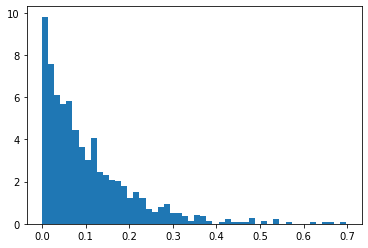

In [15]:
# suggested distribution form (gamma):
shape =  1
scale =  0.1 
s = np.random.gamma(shape, scale, 1000)
#Display the histogram of the samples:
count, bins, ignored = plt.hist(s, 50, density=True)
plt.show()

In [16]:
# Parameters:
max_n_i = 10000 # number of coverage per read
m_i =  0.7 # min(np.random.uniform(0.7, 0.15),1)
shape =  1 #gamma
scale =  0.1 #gamma

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Elapsed (seconds): 8.44


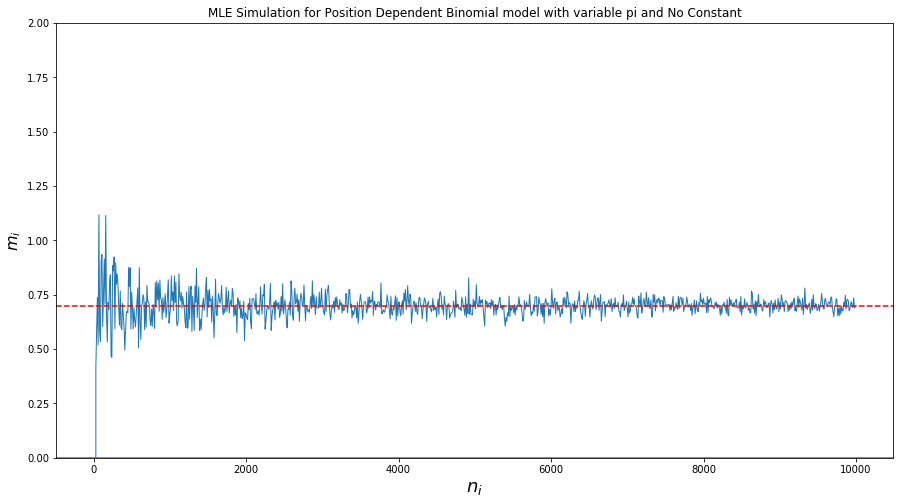

In [17]:
t = time.time()
# Plotting the simulation per coverage size:
est_list = []
rng = range(10,max_n_i,10)
for i in rng:
    pi_i = np.random.gamma(shape, scale, i)
    tmp = pi_i*m_i
    tmp[tmp>0.8]=0.8
    t_i = np.random.binomial(1,tmp)
    solution = fsolve(FOC_noConstant, m_i_initial_guess,args=(i,pi_i))[0]
    #solution = sp.optimize.brentq(FOC_noConstant,a = 1e-40, b = 1-1e-40,args=(i,pi_i))
    est_list.append(solution)
print('Elapsed (seconds): {:,}'.format(round(time.time() - t,2)))
# Plotting simulation:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.plot(list(rng),est_list,lw = 1)
ax.axhline(y=m_i, color = 'red', ls='--')
ax.set_title('MLE Simulation for Position Dependent Binomial model with variable pi and No Constant')
plt.xlabel('$n_i$', fontsize=18)
plt.ylabel('$m_i$', fontsize=16)
plt.ylim([0,2])
ax.axhline()
plt.show()

# Position Dependent Binomial Model

Let's complicate by   removing the $\quad \theta_{i,j} = \pi_{i,j}^1 m_i $ simplification:


In [18]:
# Parameters:
max_n_i = 10000 # number of coverage per read
m_i =  0.7 # min(np.random.uniform(0.7, 0.15),1)
# suggested distribution form (gamma):
# Coefficient:
shape =  1
scale =  0.1  
# Constant:
shape_zero =  0.5
scale_Zero =  0.1 

In [19]:
# MLE with  constant:
def FOC_zero(M_i,n_i,pi_i,pi_i_zero):    
    A = ((t_i*pi_i)/(pi_i_zero+pi_i*M_i)).sum()
    oneMinusT = np.array([1]*n_i)-np.array(t_i)
    oneMinusTheta = np.array([1]*n_i)-pi_i_zero-pi_i*M_i
    B = ((oneMinusT*pi_i)/(oneMinusTheta)).sum()
    return (A-B)

Elapsed (seconds): 9.38


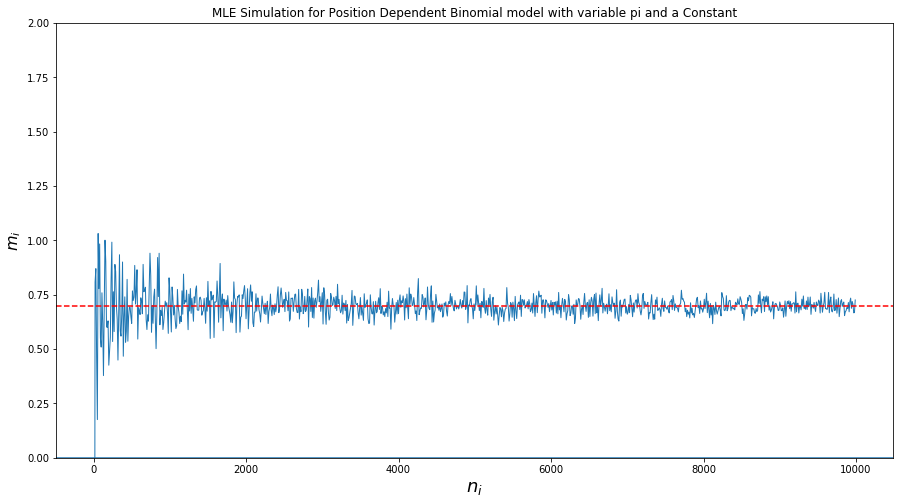

In [20]:
t = time.time()
# Plotting the simulation per coverage size:
est_list = []
rng = range(10,max_n_i,10)
for i in rng:
    pi_i = np.random.gamma(shape, scale, i)
    pi_i_zero = np.random.gamma(shape_zero, scale_Zero, i)
    tmp = pi_i_zero+pi_i*m_i
    tmp[tmp>0.8]=0.8
    t_i = np.random.binomial(1,tmp)
    solution = fsolve(FOC_zero, m_i_initial_guess,args=(i,pi_i,pi_i_zero))[0]
    #solution = sp.optimize.brentq(FOC,a = 1e-40, b = 1-1e-40,args=(i,pi_i))
    est_list.append(solution)
print('Elapsed (seconds): {:,}'.format(round(time.time() - t,2)))
# Plotting simulation:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(111)
ax.plot(list(rng),est_list,lw = 1)
ax.axhline(y=m_i, color = 'red', ls='--')
ax.set_title('MLE Simulation for Position Dependent Binomial model with variable pi and a Constant')
plt.xlabel('$n_i$', fontsize=18)
plt.ylabel('$m_i$', fontsize=16)
plt.ylim([0,2])
ax.axhline()
plt.show()

# Position Dependent GLM Model

## WORK IN PROGRESS
(I still have a few issues here)

The Model:

We have:  
$t_{i,j} \sim Bern(\theta_{i,j}) \quad \text{where} \quad \theta_{i,j} = \pi_{i,j}^1 m_i +\pi_{i,j}^0  (1- m_i)$  
Or the simplified case:   $\quad \theta_{i,j} = \pi_{i,j}^1 m_i $


$t_{i,j}∼Bernoulli(\theta_{i,j})$    
and 
$\theta_{i} = \pi_i \beta$ 



$\theta_{i,j}=\alpha+\beta*\pi_{i,j}$

nothing is normal, so least squares,t and F tests, and so forth make no sense.  
But maximum likelihood, the asymptotics of maximum likelihood estimates,   
and likelihood ratio tests do make sense.

The maximum likelihood estimates can be found using an iteratively   
reweighted least squares algorithm or a Newton's method 

"quasi-likelihood"

We generate $t_{i,j}$ according to $Bern(\theta_{i,j})$:

In [21]:
#Setting Parameters:
n_i = 300
m_i = 0.7
p_i = [1*0.2]*n_i
t_i = []
for k in p_i:
    t_i.append(np.random.binomial(1,k*m_i,1)[0])


In [22]:
df = pd.DataFrame({"t_i": t_i,
                   "p_i": p_i})

model = sm.formula.glm("t_i ~ 0 + p_i",family=sm.families.Binomial(link=sm.families.links.identity), data=df ).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    t_i   No. Observations:                  300
Model:                            GLM   Df Residuals:                      299
Model Family:                Binomial   Df Model:                            0
Link Function:               identity   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -125.06
Date:                Mon, 13 Apr 2020   Deviance:                       250.13
Time:                        15:40:04   Pearson chi2:                     300.
No. Iterations:                     2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p_i            0.7333      0.102      7.181      0.0

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)
